In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, precision_recall_curve
import joblib
import warnings
warnings.filterwarnings("ignore")

### Reading the dataset

In [2]:
df = pd.read_csv('../assets/preprocessed_fraud_dataset_numerical_only.csv')
print("Dataset shape:", df.shape)
print("\nFirst 5 rows:")
print(df.head())

Dataset shape: (50000, 16)

First 5 rows:
   Transaction_Amount  Account_Balance  IP_Address_Flag  \
0           -0.977403         1.603525          -0.2305   
1           -0.231783         0.699585          -0.2305   
2           -0.910014        -1.545712          -0.2305   
3            0.752375         1.683443          -0.2305   
4           -0.966795        -1.541124          -0.2305   

   Previous_Fraudulent_Activity  Daily_Transaction_Count  \
0                     -0.331385                -0.369026   
1                      3.017634                -1.360450   
2                     -0.331385                -0.121171   
3                     -0.331385                 0.622397   
4                     -0.331385                 0.126685   

   Avg_Transaction_Amount_7d  Failed_Transaction_Count_7d  \
0                  -1.250604                     0.707213   
1                   0.151653                    -0.705448   
2                   0.054887                    -0.705448  

### Separate features and target

In [3]:
X = df.drop('Fraud_Label', axis=1)
y = df['Fraud_Label']
print("\nFeatures being used:", X.columns.tolist())


Features being used: ['Transaction_Amount', 'Account_Balance', 'IP_Address_Flag', 'Previous_Fraudulent_Activity', 'Daily_Transaction_Count', 'Avg_Transaction_Amount_7d', 'Failed_Transaction_Count_7d', 'Transaction_Distance', 'Risk_Score', 'Is_Weekend', 'Hour', 'DayOfWeek', 'Is_Night', 'Amount_to_Balance_Ratio', 'Amount_Deviation']


### Split data

In [4]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print("\nClass distribution in y_train:", pd.Series(y_train).value_counts(normalize=True))
print("Class distribution in y_test:", pd.Series(y_test).value_counts(normalize=True))


Class distribution in y_train: Fraud_Label
0    0.67865
1    0.32135
Name: proportion, dtype: float64
Class distribution in y_test: Fraud_Label
0    0.6787
1    0.3213
Name: proportion, dtype: float64


### Create simplified pipeline

In [5]:
pipeline = Pipeline([
    ('classifier', XGBClassifier())
])

### Model Selection and Training

#### Define models to try

In [6]:
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, class_weight='balanced'),
    'Random Forest': RandomForestClassifier(class_weight='balanced'),
    'Gradient Boosting': GradientBoostingClassifier(),
    'XGBoost': XGBClassifier(scale_pos_weight=len(y_train[y_train==0])/len(y_train[y_train==1]))
}

In [7]:
print("Columns in dataframe:", df.columns.tolist())

Columns in dataframe: ['Transaction_Amount', 'Account_Balance', 'IP_Address_Flag', 'Previous_Fraudulent_Activity', 'Daily_Transaction_Count', 'Avg_Transaction_Amount_7d', 'Failed_Transaction_Count_7d', 'Transaction_Distance', 'Risk_Score', 'Is_Weekend', 'Hour', 'DayOfWeek', 'Is_Night', 'Amount_to_Balance_Ratio', 'Amount_Deviation', 'Fraud_Label']


#### Train and evaluate models


=== Model Evaluation ===

Logistic Regression Performance:
ROC-AUC: 0.9013
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.80      0.85      6787
           1       0.66      0.81      0.73      3213

    accuracy                           0.80     10000
   macro avg       0.78      0.80      0.79     10000
weighted avg       0.82      0.80      0.81     10000



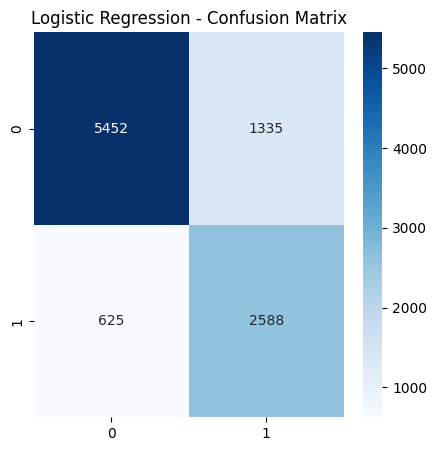


Random Forest Performance:
ROC-AUC: 1.0000
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6787
           1       1.00      1.00      1.00      3213

    accuracy                           1.00     10000
   macro avg       1.00      1.00      1.00     10000
weighted avg       1.00      1.00      1.00     10000



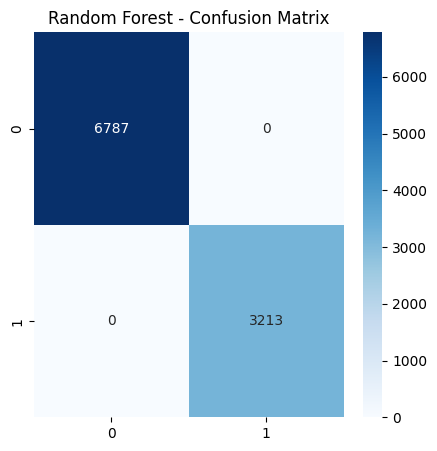


Gradient Boosting Performance:
ROC-AUC: 1.0000
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6787
           1       1.00      1.00      1.00      3213

    accuracy                           1.00     10000
   macro avg       1.00      1.00      1.00     10000
weighted avg       1.00      1.00      1.00     10000



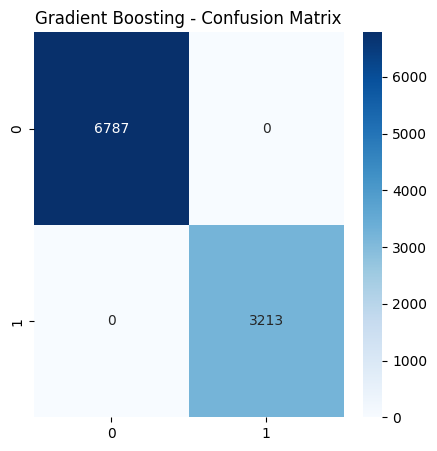


XGBoost Performance:
ROC-AUC: 1.0000
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6787
           1       1.00      1.00      1.00      3213

    accuracy                           1.00     10000
   macro avg       1.00      1.00      1.00     10000
weighted avg       1.00      1.00      1.00     10000



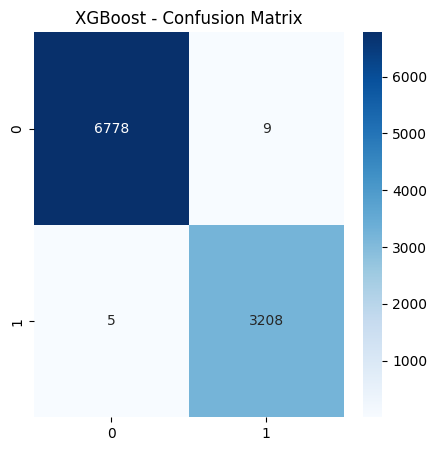

In [8]:
results = {}
print("\n=== Model Evaluation ===")
for name, model in models.items():
    # Update pipeline with current model
    current_pipeline = pipeline.set_params(classifier=model)
    
    # Train model
    current_pipeline.fit(X_train, y_train)
    
    # Evaluate
    y_pred = current_pipeline.predict(X_test)
    y_proba = current_pipeline.predict_proba(X_test)[:, 1]
    
    # Store results
    results[name] = {
        'roc_auc': roc_auc_score(y_test, y_proba),
        'precision_recall': classification_report(y_test, y_pred)
    }
    
    # Print results
    print(f"\n{name} Performance:")
    print(f"ROC-AUC: {results[name]['roc_auc']:.4f}")
    print("Classification Report:")
    print(results[name]['precision_recall'])
    
    # Plot confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'{name} - Confusion Matrix')
    plt.show()

### Hyperparameter Tuning (XGBoost)

#### Create pipeline with XGBoost

#### Define parameter grid

In [9]:
print("\n=== Hyperparameter Tuning for XGBoost ===")
param_grid = {
    'classifier__max_depth': [3, 5, 7],
    'classifier__learning_rate': [0.01, 0.1, 0.2],
    'classifier__subsample': [0.8, 1.0],
    'classifier__colsample_bytree': [0.8, 1.0],
    'classifier__n_estimators': [100, 200]
}


=== Hyperparameter Tuning for XGBoost ===


#### Perform grid search

In [10]:
grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)

In [11]:
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 72 candidates, totalling 360 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('classifier',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      callbacks=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      device=None,
                                                      early_stopping_rounds=None,
                                                      enable_categorical=False,
                                                      eval_metric=None,
                                                      feature_types=None,
                                                      feature_weights=None,
                                                      gamma=None,
                                                      grow_policy=None,
                                                      importance_type=No...
                                                      missing=nan,
                                                      monotone_constraints=None,
                                                      multi_strategy=None,
                                                      n_estimators=None,
                                                      n_jobs=None,
                                                      num_parallel_tree=None, ...))]),
             n_jobs=-1,
             param_grid={'classifier__colsample_bytree': [0.8, 1.0],
                         'classifier__learning_rate': [0.01, 0.1, 0.2],
                         'classifier__max_depth': [3, 5, 7],
                         'classifier__n_estimators': [100, 200],
                         'classifier__subsample': [0.8, 1.0]},
             scoring='roc_auc', verbose=1)

#### Best model

In [12]:
best_model = grid_search.best_estimator_
print(f"\nBest parameters: {grid_search.best_params_}")
print(f"Best ROC-AUC: {grid_search.best_score_:.4f}")


Best parameters: {'classifier__colsample_bytree': 0.8, 'classifier__learning_rate': 0.01, 'classifier__max_depth': 5, 'classifier__n_estimators': 200, 'classifier__subsample': 0.8}
Best ROC-AUC: 1.0000


#### Get feature importances from best model

In [13]:
importances = best_model.named_steps['classifier'].feature_importances_
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importances
}).sort_values('Importance', ascending=False)

#### Plot

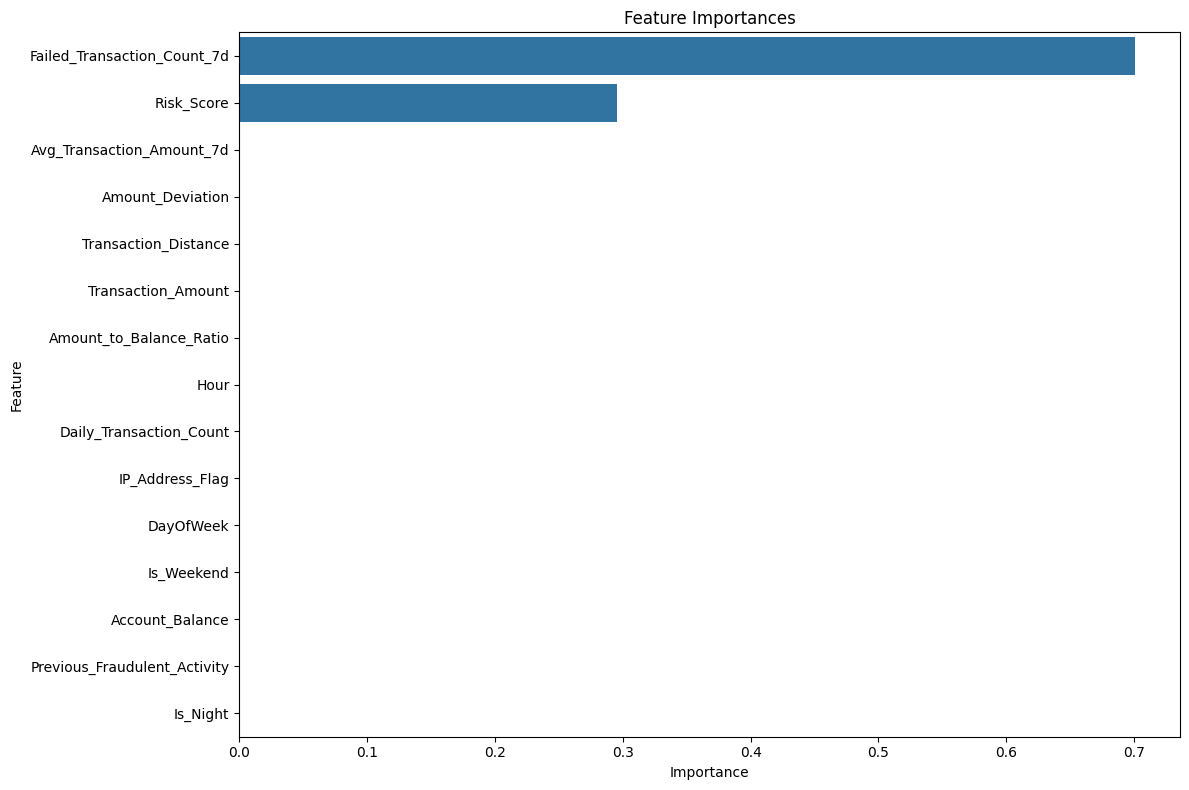

In [14]:
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Feature Importances')
plt.tight_layout()
plt.show()

### Final Model Evaluation

In [15]:
print("\n=== Final Model Evaluation ===")
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]


=== Final Model Evaluation ===


In [16]:
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("ROC-AUC Score:", roc_auc_score(y_test, y_proba))

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6787
           1       1.00      1.00      1.00      3213

    accuracy                           1.00     10000
   macro avg       1.00      1.00      1.00     10000
weighted avg       1.00      1.00      1.00     10000

ROC-AUC Score: 0.9999934882192486


### Precision-Recall Curve

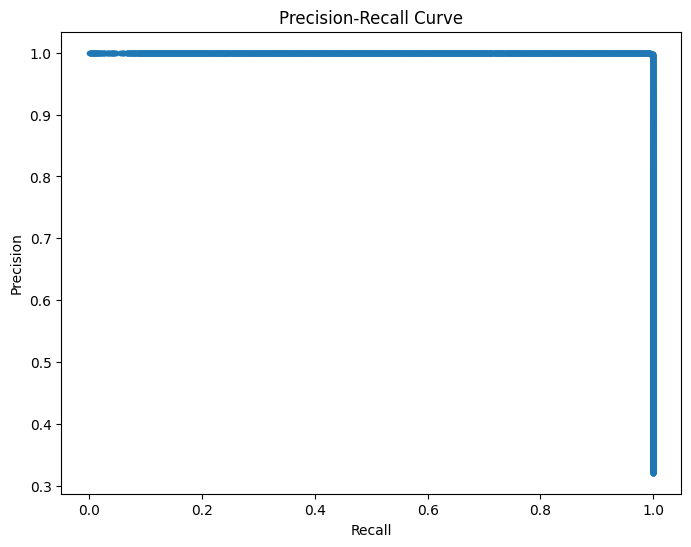

In [17]:
precision, recall, _ = precision_recall_curve(y_test, y_proba)
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

### Save the model

In [19]:
model_metadata = {
    'model': best_model,
    'feature_names': X.columns.tolist(),
    'model_params': grid_search.best_params_
}

In [20]:
joblib.dump(model_metadata, '../assets/fraud_detection_model_numerical.pkl')
print("\nModel saved successfully with metadata.")


Model saved successfully with metadata.


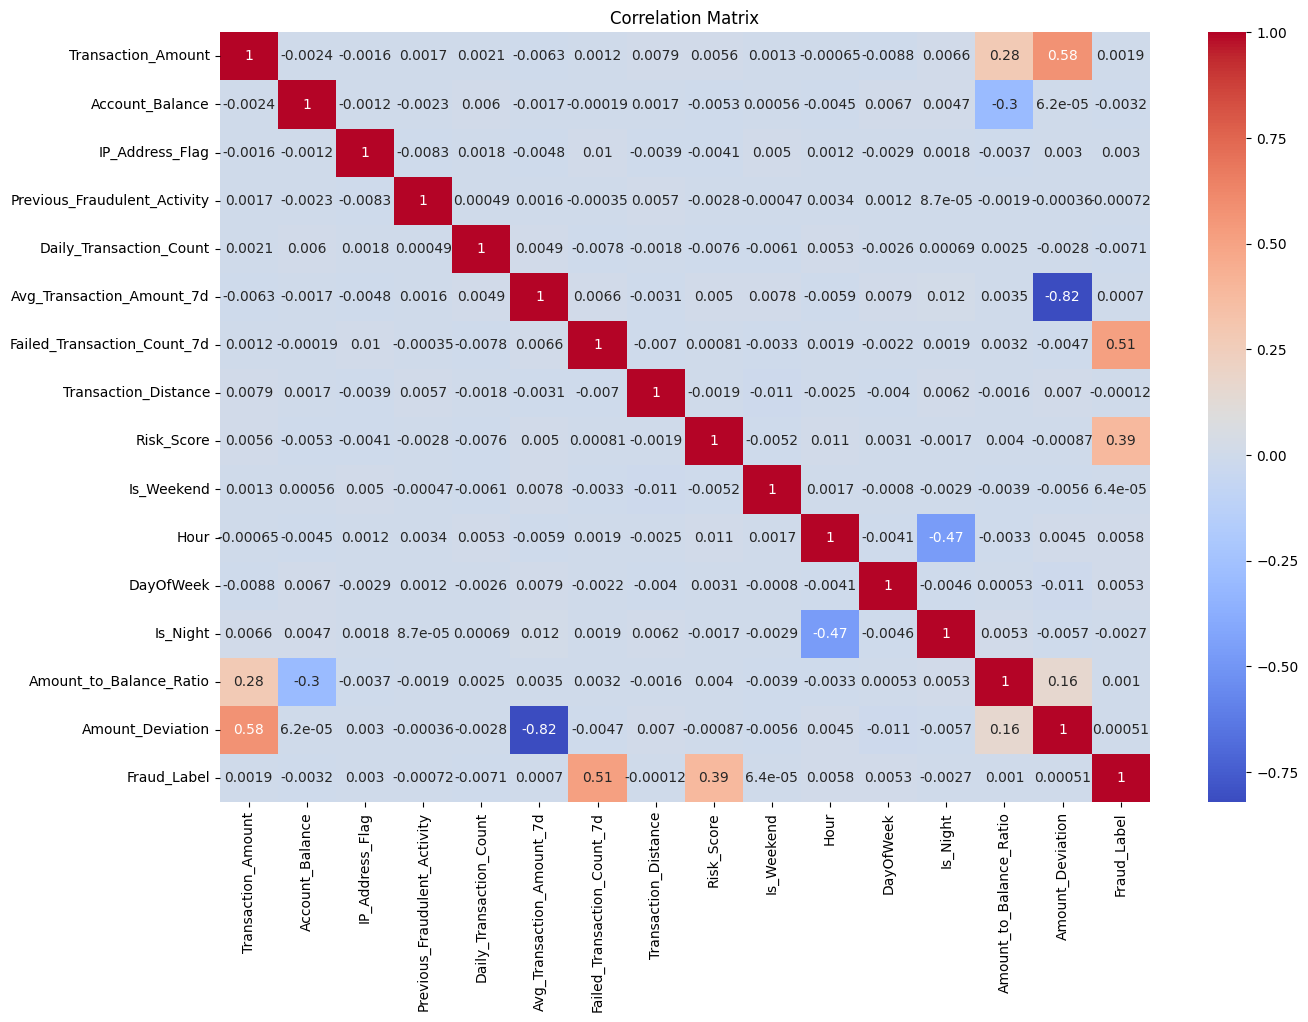

In [21]:
plt.figure(figsize=(15, 10))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()